In [1]:
! pip install -q transformers datasets evaluate jiwer bitsandbytes

In [2]:
from huggingface_hub import login
from google.colab import userdata

In [3]:
login(token=userdata.get('niru_hf_read'))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
from datasets import load_dataset

ds = load_dataset("tempertrash/image-captions-dataset")
ds = ds['train'].select(range(800))
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['image', 'caption'],
    num_rows: 800
})

In [5]:
ds = ds.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

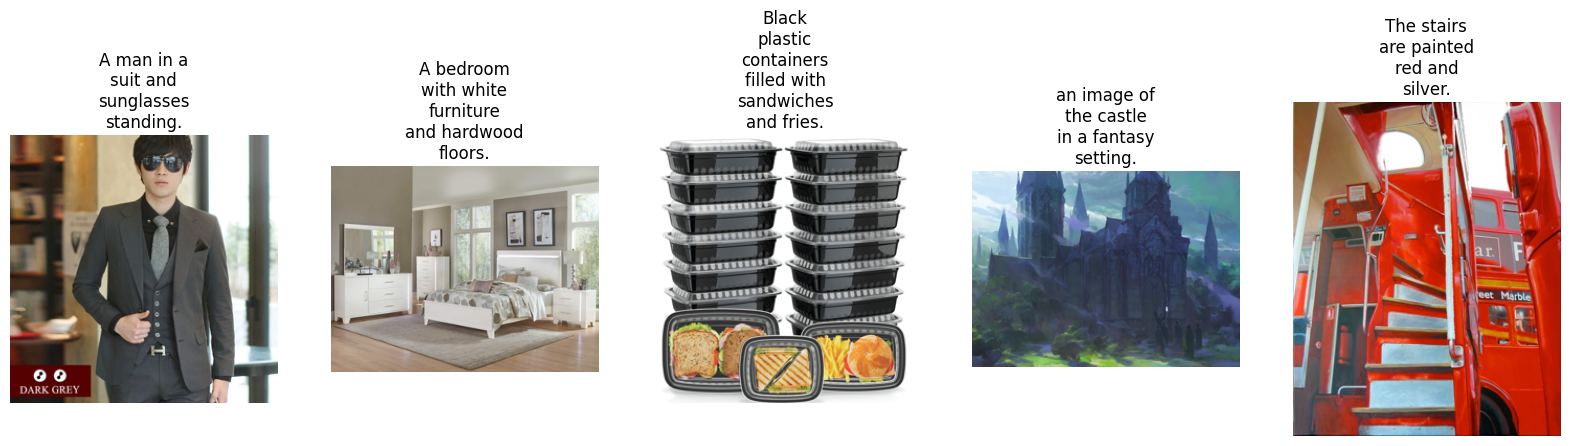

In [6]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["caption"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [7]:
from transformers import AutoProcessor, AutoModelForCausalLM

model = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(model)

# Data Preprocessiing

In [8]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["caption"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

Image captioning models are typically evaluated with the Word Error Rate (WER).

In [9]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

# Train

In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir= "/results",
    learning_rate=5e-5,
    num_train_epochs=20,
    fp16=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=32,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

Step,Training Loss,Validation Loss,Wer Score
50,7.097700,4.388649,22.437845
100,2.334600,0.524599,15.298343
150,0.181700,0.051230,5.976519
200,0.023300,0.042778,12.526243
250,0.007700,0.042833,12.921271
300,0.003900,0.043076,12.000000
350,0.002700,0.043382,12.276243
400,0.002300,0.043467,12.001381


TrainOutput(global_step=440, training_loss=1.0972413693300702, metrics={'train_runtime': 1189.4857, 'train_samples_per_second': 12.106, 'train_steps_per_second': 0.37, 'total_flos': 6584971540561920.0, 'train_loss': 1.0972413693300702, 'epoch': 19.555555555555557})

# Inference

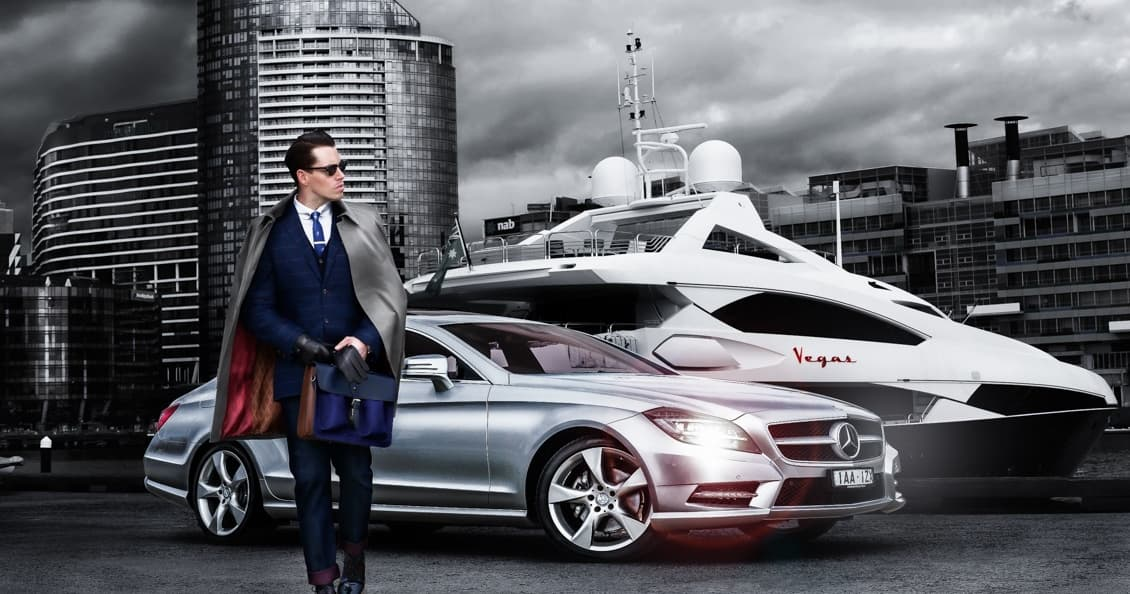

In [20]:
from PIL import Image
import requests

url = "https://imgix.ranker.com/list_img_v2/15825/315825/original/most-popular-cars-for-men-u1"
image = Image.open(requests.get(url, stream=True).raw)
image

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [23]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a man in a suit and tie sitting in front of a car.
